In [27]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split,KFold,cross_val_score, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [28]:
data_path = "Dataset/heg_sample_data.csv"
heg_meta = pd.read_csv(data_path)

drop_columns = ["days_from_entrance",
                "delta_collect_timestamp_t-t1",
                "delta_collect_timestamp_t1-t2",
                "delta_document.temperatura_t2-t3",
                "delta_document.temperatura_t3-t4",
                "outcome"]

data_x = heg_meta.drop(columns = drop_columns)
data_x.columns = data_x.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

data_y = heg_meta[['outcome']]

In [29]:
data_y.value_counts()

outcome
0.0        11970
1.0         1682
dtype: int64

# Train, Val, Test Split
    - split ratio = 6 : 2 : 2
    - split ratio = 8 : 1 : 1
    
    - 10 times, 20 times, 30 times -> 여러 번의 split ACC나, f1 - score 등의 mean, std을 통해 오차값을 가진 성능 표현

## Stratified K-fold (6:2:2)

In [10]:
"""X_train_val, X_test, y_train_val, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y
)

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for train_index, val_index in skf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    break  

print(f"Train Length : {len(X_train)}, Val Length : {len(X_val)}, Test Length : {len(X_test)}")"""

Train Length : 8190, Val Length : 2731, Test Length : 2731


# Data Preprocessing

### Data Normalization
    - Z - score 
    - min - max Scaling

In [5]:
## Z - score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train_transposed = scaler.fit(X_train)  

## Min-Max Scaler
scaler = MinMaxScaler()
X_train_transposed = scaler.fit(X_train)

### Methods for imbalanced Data

### Modeling 
    - LightGBM
    - XGBoost
    - RandomForest
    - Decision Tree
    - Linear Regression
    - etc
    

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

In [31]:
def learning_model(model, train_x, train_y):
    model.fit(train_x, train_y)
    return model

def f1_marco(model,val_x, val_y):
    predictions = model.predict(val_x)
    f1_score_value = f1_score(val_y, predictions, average='macro')
    return f1_score_value

def AU_PRC(model, val_x, val_y):
    if hasattr(model, "predict_proba"):  
        probabilities = model.predict_proba(val_x)[:, 1]
    else:  
        probabilities = model.decision_function(val_x)
    precision, recall, threshold = precision_recall_curve(val_y, probabilities)
    auprc_score = auc(recall, precision)
    return auprc_score

def weighted_ACC(model, val_x, val_y):
    val_y = np.array(val_y).flatten().astype(int)
    
    predictions = model.predict(val_x)
    class_counts = np.bincount(val_y)  
    weights = class_counts / len(val_y)  
    acc_per_class = []
    
    for label in np.unique(val_y):
        idx = (val_y == label)
        acc_per_class.append(accuracy_score(val_y[idx], predictions[idx]))
    
    weighted_accuracy = np.dot(weights, acc_per_class)
    return weighted_accuracy
    

In [32]:
models = {
    'AdaBoost': AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        learning_rate=0.01,
        n_estimators=300,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42
    )
}

In [33]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y
)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

best_score = 0
best_model_name = ''
best_model = None

for name, model in tqdm(models.items(), desc="Model Training"):
    cv_scores = []
    
    for train_index, val_index in skf.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
        
        model = learning_model(model, X_train, y_train)
        
        y_val_pred = model.predict(X_val)
        cv_scores.append(f1_score(y_val, y_val_pred, average='macro'))
    
    avg_score = np.mean(cv_scores)
    print(f'{name} Average F1 Score (CV): {avg_score:.4f}')
    
    if avg_score > best_score:
        best_score = avg_score
        best_model_name = name
        best_model = model
    
    ## test Model through data.
    test_f1_score = f1_marco(model, X_test, y_test)
    test_AUPRC = AU_PRC(model, X_test, y_test)
    test_WeightedAcc = weighted_ACC(model, X_test, y_test) 
    print(f'{name} Test Scores -> F1 Score: {test_f1_score:.4f}, AUPRC: {test_AUPRC:.4f}, Weighted ACC: {test_WeightedAcc:.4f}')
    
y_test_pred = best_model.predict(X_test)
test_score = f1_score(y_test, y_test_pred, average='macro')

print(f'\nBest Model: {best_model_name} with F1 Score (CV): {best_score:.4f}')
print(f'Test F1 Score: {test_score:.4f}')

Model Training:   0%|          | 0/5 [00:00<?, ?it/s]

AdaBoost Average F1 Score (CV): 0.5361


Model Training:  20%|██        | 1/5 [00:22<01:30, 22.53s/it]

AdaBoost Test Scores -> F1 Score: 0.5382, AUPRC: 0.5669, Weighted ACC: 0.8854
Random Forest Average F1 Score (CV): 0.7273


Model Training:  40%|████      | 2/5 [00:59<01:32, 30.96s/it]

Random Forest Test Scores -> F1 Score: 0.7218, AUPRC: 0.6546, Weighted ACC: 0.9103
[08:41:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:41:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:41:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:42:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from '

Model Training:  60%|██████    | 3/5 [01:33<01:04, 32.47s/it]

XGBoost Average F1 Score (CV): 0.7587
XGBoost Test Scores -> F1 Score: 0.7539, AUPRC: 0.6798, Weighted ACC: 0.9158
[LightGBM] [Info] Number of positive: 1009, number of negative: 7181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8716
[LightGBM] [Info] Number of data points in the train set: 8190, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123199 -> initscore=-1.962479
[LightGBM] [Info] Start training from score -1.962479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

Model Training:  80%|████████  | 4/5 [01:35<00:20, 20.54s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Model Training: 100%|██████████| 5/5 [01:36<00:00, 19.36s/it]

Decision Tree Average F1 Score (CV): 0.7178
Decision Tree Test Scores -> F1 Score: 0.7202, AUPRC: 0.4992, Weighted ACC: 0.8909

Best Model: LightGBM with F1 Score (CV): 0.7624
Test F1 Score: 0.7623


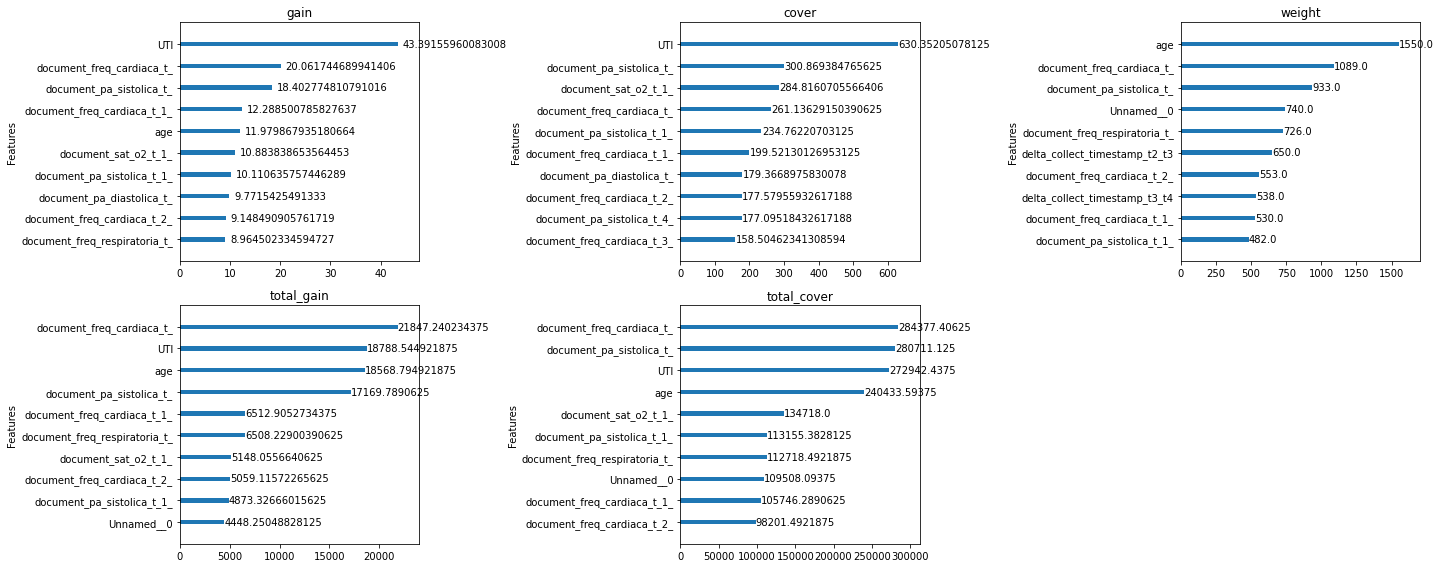

In [34]:
import xgboost as xgb

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
axes = [ax for row_axes in axes for ax in row_axes]
xgb_model = models['XGBoost']
max_features = 10

xgb.plot_importance(xgb_model, importance_type='gain', title='gain', xlabel='', grid=False, ax=axes[0], max_num_features=max_features)
xgb.plot_importance(xgb_model, importance_type='cover', title='cover', xlabel='', grid=False, ax=axes[1], max_num_features=max_features)
xgb.plot_importance(xgb_model, importance_type='weight', title='weight', xlabel='', grid=False, ax=axes[2], max_num_features=max_features)
xgb.plot_importance(xgb_model, importance_type='total_gain', title='total_gain', xlabel='', grid=False, ax=axes[3], max_num_features=max_features)
xgb.plot_importance(xgb_model, importance_type='total_cover', title='total_cover', xlabel='', grid=False, ax=axes[4], max_num_features=max_features)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [35]:
booster = xgb_model.get_booster()

feature_importance_gain = booster.get_score(importance_type='gain')
feature_importance_weight = booster.get_score(importance_type='weight')
feature_importance_cover = booster.get_score(importance_type='cover')

print("Gain 기준 특성 중요도:")
print(feature_importance_gain)

print("\nWeight 기준 특성 중요도:")
print(feature_importance_weight)

print("\nCover 기준 특성 중요도:")
print(feature_importance_cover)


Gain 기준 특성 중요도:
{'Unnamed__0': 6.0111494064331055, 'age': 11.979867935180664, 'document_sexo': 2.67318058013916, 'UTI': 43.39155960083008, 'delta_collect_timestamp_t2_t3': 5.252482891082764, 'delta_collect_timestamp_t3_t4': 4.81912088394165, 'document_freq_cardiaca_t_': 20.061744689941406, 'document_freq_cardiaca_t_1_': 12.288500785827637, 'document_freq_cardiaca_t_2_': 9.148490905761719, 'document_freq_cardiaca_t_3_': 8.071227073669434, 'document_freq_cardiaca_t_4_': 5.461866855621338, 'document_freq_respiratoria_t_': 8.964502334594727, 'document_freq_respiratoria_t_1_': 6.734111785888672, 'document_freq_respiratoria_t_2_': 5.71845817565918, 'document_freq_respiratoria_t_3_': 4.9680681228637695, 'document_freq_respiratoria_t_4_': 4.177077293395996, 'document_glicemia_capilar_t_': 4.6294121742248535, 'document_glicemia_capilar_t_1_': 3.6639721393585205, 'document_glicemia_capilar_t_2_': 3.8253719806671143, 'document_glicemia_capilar_t_3_': 3.14700984954834, 'document_glicemia_capilar_t